In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.contrib.layers as layers

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['agg.path.chunksize'] = 10000

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def model(x, reuse=False):
    fc1 = layers.fully_connected(x, 5, activation_fn=tf.nn.relu, scope='fc1', reuse=reuse)
    fc2 = layers.fully_connected(fc1, 5, activation_fn=tf.nn.relu, scope='fc2', reuse=reuse)
    y = layers.fully_connected(fc2, 1, activation_fn=None, scope='fc3', reuse=reuse)
    return y

def preprocess(X):
    """
    Scales and shifts X to have 0 mean and unit variance.
    """
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, scaler

def get_data(df, X_vars, y_var, train_test_split=1.0):
    """
    Args:
      - df: Pandas dataframe containing the input data.
      - X_vars: List of column names for the input matrix.
      - y_var: Column name for the output matrix.
    
    Returns:
        - X: Normalized input matrix containing X_vars.
        - y: Array containing the response variable.
        - scaler: Module used to normalize X.
    """
    # Filter out rows where one of the input variables and/or response variable is NaN.
    df = df[X_vars + [y_var]].dropna()
    df = df.reindex(np.random.permutation(df.index))
    df_train = df.iloc[:int(df.shape[0] * train_test_split)]
    df_test = df.iloc[int(df.shape[0] * train_test_split):]
    X_train, X_scaler = preprocess(df_train[X_vars])
    X_test = X_scaler.transform(df_test[X_vars])
    y_train = df_train[y_var]
    y_test = df_test[y_var]
    return X_train, y_train, X_test, y_test, X_scaler

In [3]:
US_Var_df = pd.read_csv("biomet_data/AMF_US-Var_BASE_HH_9-1.csv", comment = "#").replace("-9999", np.nan)
US_Ton_df = pd.read_csv("biomet_data/AMF_US-Ton_BASE_HH_9-1.csv", comment = "#").replace("-9999", np.nan)
print "Var Data: ", US_Var_df.shape
print "Tonzi Data: ", US_Ton_df.shape
print "Columns: ", US_Var_df.columns

Var Data:  (280512, 38)
Tonzi Data:  (186419, 38)
Columns:  Index([u'TIMESTAMP_START', u'TIMESTAMP_END', u'USTAR', u'TA', u'WD', u'WS',
       u'NEE_PI', u'FC', u'SC', u'H', u'SH', u'LE', u'SLE', u'G', u'TS_1',
       u'TS_2', u'P', u'RH', u'PA', u'CO2_1', u'CO2_2', u'VPD_PI', u'SWC_1',
       u'SWC_2', u'NETRAD', u'PPFD_IN', u'SW_IN', u'SW_DIF', u'PPFD_OUT',
       u'SW_OUT', u'LW_IN', u'LW_OUT', u'H2O', u'RECO_PI', u'APAR',
       u'PPFD_DIF', u'FAPAR', u'ZL'],
      dtype='object')


X_train:  (174410, 1)


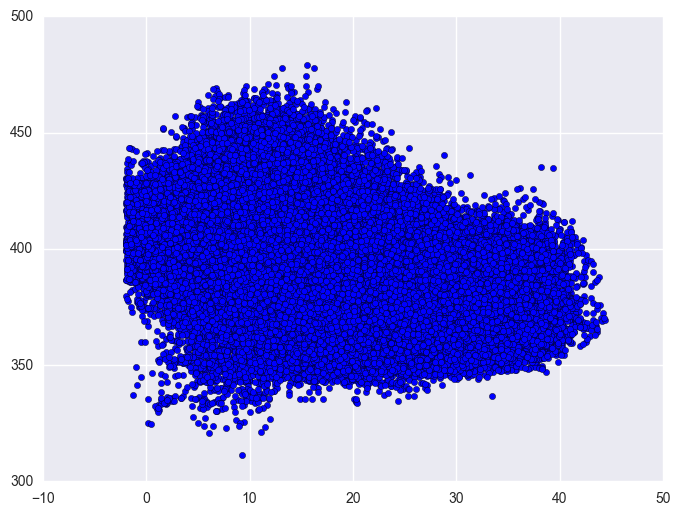

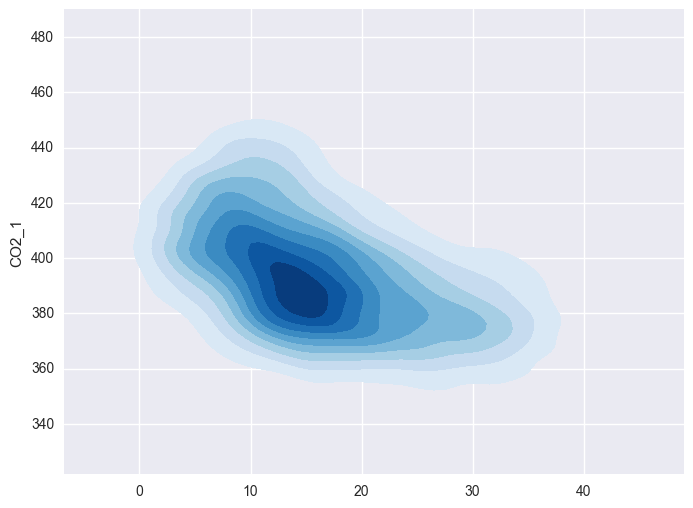

In [4]:
X_vars, y_var, train_test_split = ['TA'], 'CO2_1', 0.8
X_train, y_train, X_val, y_val, X_scaler = get_data(US_Var_df, X_vars, y_var, train_test_split)
print "X_train: ", X_train.shape
if X_train.shape[1] == 1:
    plt.scatter(X_scaler.inverse_transform(X_train), y_train)
    plt.show()
    sns.kdeplot(X_scaler.inverse_transform(X_train[:20000, 0]), y_train[:20000], cmap="Blues", shade=True, shade_lowest=False)
elif X_train.shape[1] == 2:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_train[:, 0], X_train[:, 1], y_train)
else:
    print "Cannot plot data when in {0}-D!".format(X_train.shape[1] + 1)

Epoch:  0 Batch:  0 MSE:  155303.0
Epoch:  0 Batch:  500 MSE:  368.578
Epoch:  1 Batch:  0 MSE:  372.526
Epoch:  1 Batch:  500 MSE:  367.706
Epoch:  2 Batch:  0 MSE:  371.857
Epoch:  2 Batch:  500 MSE:  367.377
Epoch:  3 Batch:  0 MSE:  371.514
Epoch:  3 Batch:  500 MSE:  367.092
Epoch:  4 Batch:  0 MSE:  371.15
Epoch:  4 Batch:  500 MSE:  366.96
Epoch:  5 Batch:  0 MSE:  370.905
Epoch:  5 Batch:  500 MSE:  366.922
Epoch:  6 Batch:  0 MSE:  370.764
Epoch:  6 Batch:  500 MSE:  366.903
Epoch:  7 Batch:  0 MSE:  370.68
Epoch:  7 Batch:  500 MSE:  366.891
Epoch:  8 Batch:  0 MSE:  370.616
Epoch:  8 Batch:  500 MSE:  366.878
Epoch:  9 Batch:  0 MSE:  370.562
Epoch:  9 Batch:  500 MSE:  366.861


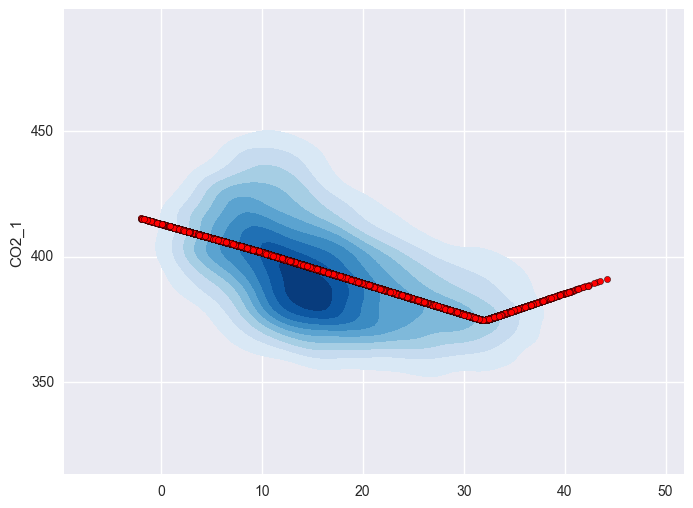

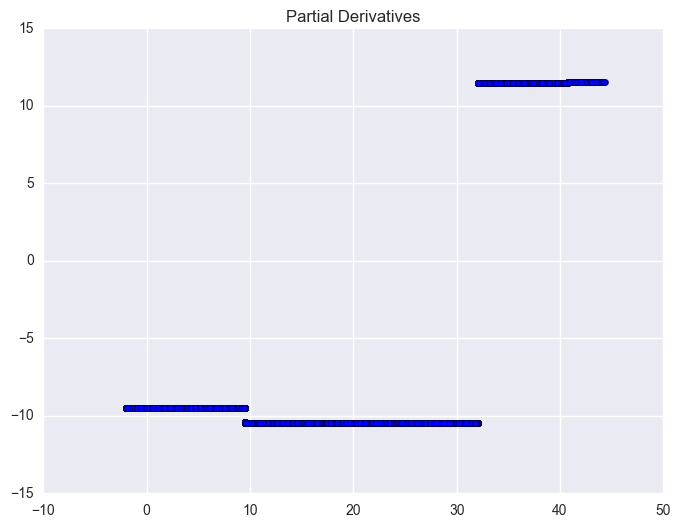

In [5]:
batch_size = 256
num_batches = X_train.shape[0] / batch_size
X_batches = np.array_split(X_train, num_batches)
y_batches = np.array_split(y_train.values.reshape(-1, 1), num_batches)

x = tf.placeholder(tf.float32, shape=[None, X_train.shape[1]])
y = tf.placeholder(tf.float32, shape=[None, 1])
y_pred = model(x, reuse=False)

# Minimize the mean squared errors.
loss = tf.reduce_mean(tf.square(y_pred - y))
optimizer = tf.train.GradientDescentOptimizer(0.00001)
train = optimizer.minimize(loss)

partial_x = tf.gradients(y_pred, x)

# Before starting, initialize the variables.  We will 'run' this first.
init = tf.initialize_all_variables()

# Launch the graph.
sess = tf.Session()
sess.run(init)

with tf.Graph().as_default(), sess.as_default():
    for epoch in xrange(10):
        for i in xrange(num_batches):
            _, batch_loss = sess.run([train, loss], feed_dict={x: X_batches[i], y: y_batches[i]})
            if i % 500 == 0:
                print "Epoch: ", epoch, "Batch: ", i, "MSE: ", batch_loss
    preds, partials = sess.run([y_pred, partial_x], feed_dict={x: X_train})

# Plot the first 20000 samples, already randomly shuffled, to save performance.
sns.kdeplot(X_scaler.inverse_transform(X_train[:20000, 0]), y_train[:20000], cmap="Blues", shade=True, shade_lowest=False)
plt.scatter(X_scaler.inverse_transform(X_train[:20000, 0]), preds[:20000, 0], c='r')
plt.show()
plt.title("Partial Derivatives")
plt.scatter(X_scaler.inverse_transform(X_train), partials)